#### Plan for synthetic data 
1. Create synthetic datasets
2. Run synthetic unbiased fair synthetic dataset
3. add in error + bias into Y-train, make it rely on S
4. run pipeline on new data and try to get it to meet the same baseline as the original dataset for demographic parity + accuracy.

#### Additional work 
hypertune for lambda so that accuracy and demographic parity are well balanced.

In [1]:
# !pip install fairlearn

import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
import random
import datetime

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout, Concatenate
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)

from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2025-02-26 11:43:34.128367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 11:43:34.128415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 11:43:34.130059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 11:43:34.140244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -------------------------------
# Custom Gradient Reversal Layer
# -------------------------------
@tf.custom_gradient
def grad_reverse(x, lambda_):
    def grad(dy):
        return -lambda_ * dy, None # reverses direction of gradient 
    return x, grad

# custom Keras layer
"""
Layer is used to ensure that the feature representation are independent of a sensitive attribute
- feature extract learns normally in the forward pass
- reversing gradients of classifier that tries to predict the sensitive attribute during backpropagation -- stops feature extractor from encoding sensitive information
"""
class GradientReversalLayer(tf.keras.layers.Layer): 
    def __init__(self, lambda_=1.0, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.lambda_ = lambda_ # strength of gradient reversal
    def call(self, x):
        return grad_reverse(x, self.lambda_)

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
def set_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

In [3]:
# -------------------------------
# Adversarial Debiasing Model
# -------------------------------
def build_adversarial_model(input_dim, lambda_adv=1.0):
    """
    Build an adversarial debiasing model that learns pseudo‑labels Y' from X.

    Architecture:
      - Main branch (encoder): from X, several dense layers produce a latent pseudo‑label pseudo_Y (via sigmoid).
      - Adversary branch: pseudo_Y is passed through a Gradient Reversal Layer and then dense layers predict S.
      - Decoder branch: concatenates pseudo_Y and the one-hot sensitive attribute S to predict the observed label Y.

    Losses:
      - For the main branch, binary crossentropy between observed Y and pseudo_Y (and Y_pred).
      - For the adversary branch, categorical crossentropy to predict S.

    Returns a compiled Keras model that takes inputs X and S (one-hot encoded) and outputs:
      [pseudo_Y, S_pred, Y_pred].
    """
    X_input = tf.keras.Input(shape=(input_dim,), name="X")
    S_input = tf.keras.Input(shape=(2,), name="S")  # one-hot encoded S

    # Main branch: Encoder for pseudo-label.
    """
    """
    h = Dense(64, activation='relu')(X_input)
    h = BatchNormalization()(h)
    h = Dense(32, activation='relu')(h)
    h = BatchNormalization()(h)
    pseudo_Y = Dense(1, activation='sigmoid', name="pseudo_Y")(h) ## outputs  probability value for pseudo_Y between 0,1

    # Adversary branch: from pseudo_Y, with GRL.
    """
    This is to prevent psuedo_Y from containing information about S
    - adversary will try to predict S from pseudo_Y (fair label)...if it can accurately predict S, then Y' still encodes information about S (don't want this) 
    - use the gradient reversal layer to prevent this from happening
    """
    grl = GradientReversalLayer(lambda_=lambda_adv)(pseudo_Y)
    a = Dense(32, activation='relu')(grl)
    a = BatchNormalization()(a)
    S_pred = Dense(2, activation='softmax', name="S_pred")(a)

    # Decoder branch: combine pseudo_Y and S to predict observed Y.
    """
    Y depepends on both Y' and S 
    -- predict the final observed label Y using both psuedo_Y and S
    -- Y may still depend on S, that is why it's being used here 
    -- decoder ensures Y_final is accurate, while psuedo_Y is not directly influenced by S 
    -- psuedo_Y removes unfair dependencies on S...however S might still contain legit info needed to predict Y accurately 
    -- IMPORTANT - THIS STEP ALLOWS FAIR DEPENDENCIES WHILE ELIMINATING UNFAIR ONES
    -- structure how S influences Y, without letting hidden biases leak through 
    """
    concat = Concatenate()([pseudo_Y, S_input])
    d = Dense(16, activation='relu')(concat)
    d = BatchNormalization()(d)
    Y_pred = Dense(1, activation='sigmoid', name="Y_pred")(d)

    model = tf.keras.Model(inputs=[X_input, S_input],
                           outputs=[pseudo_Y, S_pred, Y_pred])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss={"pseudo_Y": "binary_crossentropy",
                        "S_pred": "categorical_crossentropy",
                        "Y_pred": "binary_crossentropy"},
                  loss_weights={"pseudo_Y": 1.0, "S_pred": lambda_adv, "Y_pred": 1.0},
                  metrics={"pseudo_Y": "accuracy",
                           "S_pred": "accuracy",
                           "Y_pred": "accuracy"}) # Y_pred is the best estimate of Y accounting for fair dependencies 
    return model

In [4]:
# -------------------------------
# Manual Fairness Metrics
# -------------------------------
def compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually.
    y_true: binary ground-truth labels (1-D numpy array).
    y_pred: continuous scores (will be thresholded at 0.5).
    sensitive_features: 1-D numpy array (0 or 1).

    Returns a dictionary with:
      - Demographic parity difference (absolute difference in positive rates).
      - Equalized odds difference (average difference in TPR and FPR).
      - Selection rates per group.
      - Group-wise accuracy.
    """
    y_pred_bin = (y_pred > 0.5).astype(int) # y_pred is continuous value, so converting it to binary 
    groups = np.unique(sensitive_features)

    # Demographic parity 
    """
    All groups (from sensitive feature) should receive positive predictions at the same rate
    P(Y_hat = 1|S=0) = P(Y_hat=1|S=1)
    """

    # For each group in the sensitive feature, find the demographic parity and compute the difference (based on the formula in above comment)
    pos_rates = {}
    for g in groups: 
        pos_rates[g] = np.mean(y_pred_bin[sensitive_features == g])
    dp_diff = abs(pos_rates[0] - pos_rates[1]) ## this line assumes that there are only 2 groups, 0 and 1 -- if there are more than 2 groups, this would need to be changed
    ## in all the examples used, there were only 2 groups -- need to double check this when working on new data
    
    # dp_diff > 0, then demographic parity isn't fair 

    # Equalized odds
    """
    Ensuring the different groups in the sensitive feature similar TPR and FPR rates -- this is so that the model isn't discriminating in error types
    """
    metrics = {}
    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred_bin[mask]
        tpr = np.sum((y_pred_g == 1) & (y_true_g == 1)) / (np.sum(y_true_g == 1) + 1e-8) # True Positive Rate
        fpr = np.sum((y_pred_g == 1) & (y_true_g == 0)) / (np.sum(y_true_g == 0) + 1e-8) # False Positive Rate
        metrics[g] = (tpr, fpr)
    eo_diff = (abs(metrics[0][0] - metrics[1][0]) + abs(metrics[0][1] - metrics[1][1])) / 2# taking average of two error types

    # Selection rate per group.
    """
    proportion of samples predicted as positive for each group -- a a group has a higher selection rate, the model may favor that group unfairly
    """
    sel_rate = {}
    for g in groups:
        sel_rate[g] = pos_rates[g]

    # Group-wise accuracy.
    """
    for each group in the sensitive feature, compute the accuracy of the model (to ensure that it's perfoming consistently across groups)
    """
    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred_bin[mask])

    return {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": sel_rate,
        "group_accuracy": group_acc
    }

In [5]:
# -------------------------------
# Plotting Function
# -------------------------------
def plot_comparison(metrics_baseline, metrics_fair):
    """
    parameters are dictionaries with the stored values of the evaluation metrics
    """
    models = ['Baseline', 'Fair']
    aucs = [metrics_baseline['auc'], metrics_fair['auc']]
    accs = [metrics_baseline['accuracy'], metrics_fair['accuracy']]
    dp_diff = [metrics_baseline["demographic_parity_difference"], metrics_fair["demographic_parity_difference"]]
    eo_diff = [metrics_baseline["equalized_odds_difference"], metrics_fair["equalized_odds_difference"]]

    # creating a 2x3 gird of bar chars comparing baseline model and fair model across: AUC, accuracy, demographic parity diff, equalized odd difference
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    ## measures how well the model seperates postiive and negative classes, higher AUC = better model performance
    # if fair model has a lower AUC than the baseline, can indicate a fairness-performance tradeoff (meaning less well seperation for more fair results)
    axs[0,0].bar(models, aucs, color=['blue', 'green'])
    axs[0,0].set_title('AUC')
    axs[0,0].set_ylim([0, 1])

    ## correct pred/total pred
    ## fairness may lower accuracy 
    axs[0,1].bar(models, accs, color=['blue', 'green'])
    axs[0,1].set_title('Accuracy')
    axs[0,1].set_ylim([0, 1])

    ## orange = baseline, purple = fairness -LOOK INTO TO SEE HOW TO KNOW WHICH GROUP IS CONTRIBUTING TO HIGHER DP
    # lower values of dp indciate better fairness
    axs[1,0].bar(models, dp_diff, color=['orange', 'purple'])
    axs[1,0].set_title('Demographic Parity Difference')

    ## lower value - better fairness
    ## equalized odds is satisfied if tpr and fpr are equal across the different groups in the sensitive feature
    axs[1,1].bar(models, eo_diff, color=['orange', 'purple'])
    axs[1,1].set_title('Equalized Odds Difference')

    plt.suptitle("Comparison: Baseline (X → Y) vs. Fair (X → Y') Model")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [20]:
# -------------------------------
# Main Function: Comparison and Visualization
# -------------------------------
def main(data_url, dataset_name, lambda_adv=1.0):
    set_seed(42)

    if dataset_name == "compas": 
        X, Y_obs, S = load_and_preprocess_compas_data_binary(data_url) ##  S is binary

    elif dataset_name == "german":
        X, Y_obs, S = load_and_preprocess_german_data(data_url) ##  S is binary

    elif dataset_name == "adult":
        X, Y_obs, S = load_and_preprocess_adult_data(data_url) ##  S is binary

    elif dataset_name == "synthetic-unbiased": 
        X, Y_obs, S = generate_synthetic_data() ##  Y is binary class, S is binary

    else:
        print ("Invalid dataset_name")
        return 
    

    print(f"Loading and preprocessing {dataset_name} data...")
    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y_obs, S, test_size=0.2, random_state=42
    )

    if dataset_name == "compas":
        print(f"Features shape: {X.shape}")
        print(f"Observed Label Y shape: {Y_obs.shape}   (Recidivism: 1=recid, 0=non-recid)")
        print(f"Sensitive Attribute (Race, binarized) shape: {S.shape}")
        
    elif dataset_name == "german": 
        print(f"Features shape: {X.shape}")
        print(f"Observed Label Y shape: {Y_obs.shape}   (Credit risk: 1=good, 0=bad)")
        print(f"Sensitive Attribute (Age, binarized) shape: {S.shape}")
        
    elif dataset_name == "adult":
        print(f"Features shape: {X.shape}")
        print(f"Observed Label Y shape: {Y_obs.shape}   (Label from 'income')")
        print(f"Sensitive Attribute (Sex) shape: {S.shape}")

    input_dim = X_train.shape[1]

    # One-hot encode S for adversarial model training.
    S_train_oh = tf.keras.utils.to_categorical(S_train, num_classes=2)
    S_test_oh  = tf.keras.utils.to_categorical(S_test, num_classes=2)

    ### 1. Train adversarial debiasing model (X → Y' with adversary)
    print("\nTraining adversarial model (X → Y' with adversary) ...")
    adv_model = build_adversarial_model(input_dim, lambda_adv=lambda_adv)
    # For training, we use the observed Y as target for both pseudo_Y and Y_pred.
    # Reshape Y_obs to (-1,1) since our outputs are scalars.
    Y_train_obs_exp = Y_train_obs.reshape(-1, 1)
    Y_test_obs_exp  = Y_test_obs.reshape(-1, 1)

    # adv_model.fit([X_train, S_train_oh],
    #               {"pseudo_Y": Y_train_obs_exp, "S_pred": S_train_oh, "Y_pred": Y_train_obs_exp},
    #               epochs=64, batch_size=128, verbose=1)
    
    adv_model.fit([X_train, S_train_oh],
                  {"pseudo_Y": Y_train_obs_exp, "S_pred": S_train_oh, "Y_pred": Y_train_obs_exp},
                  epochs=30, batch_size=128, verbose=1)

    # Get pseudo-label predictions.
    pseudo_Y_train, S_pred, Y_pred_train = adv_model.predict([X_train, S_train_oh]) ## do we want psuedo_Y or Y_pred? psuedo_Y is for complete fairness why pred_Y can be a bit more accurate by keep necessary dependencies
    pseudo_Y_test,  S_pred, Y_pred_test = adv_model.predict([X_test, S_test_oh])

    # Threshold pseudo-labels to get binary labels.
    # THIS IS WITH PSUEDO_Y -- assuming that there is complete independence bewteen S and Y -- USE THIS!!
    Y_pred_train_bin = (pseudo_Y_train > 0.5).astype(np.float32)
    Y_pred_test_bin  = (pseudo_Y_test > 0.5).astype(np.float32)

    # THIS IS WITH Y_PRED
    # Y_pred_train_bin = (Y_pred_train > 0.5).astype(np.float32)
    # Y_pred_test_bin  = (Y_pred_test > 0.5).astype(np.float32)

    print("\nPseudo-label statistics (training):")
    for g in np.unique(S_train):
        mask = (S_train == g)
        print(f"Group {g} pseudo-positive rate: {np.mean(Y_pred_train_bin[mask]):.4f}") # average probability of a postive prediction per group -- fairness check to see if both groups receive similar treatment

    ### 2. Train baseline logistic regression model on observed Y (X → Y) -- regular logistic regression for baseline for comparison; does not include any fairness constraints
    print("\nTraining baseline logistic regression classifier (X → Y)...")
    baseline_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    baseline_clf.fit(X_train, Y_train_obs)
    baseline_preds = baseline_clf.predict_proba(X_test)[:, 1]
    baseline_auc = roc_auc_score(Y_test_obs, baseline_preds)
    baseline_acc = accuracy_score(Y_test_obs, (baseline_preds > 0.5).astype(int))
    baseline_fairness = compute_fairness_metrics_manual(Y_test_obs, baseline_preds, sensitive_features=S_test)

    ### 3. Train fair logistic regression model on pseudo-labels (X → Y') -- using psuedo_Y from the the adv_model, 
    print("\nTraining fair logistic regression classifier (X → Y') using pseudo-labels...")
    fair_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    fair_clf.fit(X_train, Y_pred_train_bin.ravel())
    fair_preds = fair_clf.predict_proba(X_test)[:, 1]
    fair_auc = roc_auc_score(Y_test_obs, fair_preds)
    fair_acc = accuracy_score(Y_test_obs, (fair_preds > 0.5).astype(int))
    fair_fairness = compute_fairness_metrics_manual(Y_test_obs, fair_preds, sensitive_features=S_test)

    # Aggregate metrics for plotting.
    metrics_baseline = {
        "auc": baseline_auc,
        "accuracy": baseline_acc,
        "demographic_parity_difference": baseline_fairness["demographic_parity_difference"],
        "equalized_odds_difference": baseline_fairness["equalized_odds_difference"]
    }
    metrics_fair = {
        "auc": fair_auc,
        "accuracy": fair_acc,
        "demographic_parity_difference": fair_fairness["demographic_parity_difference"],
        "equalized_odds_difference": fair_fairness["equalized_odds_difference"]
    }

    print("\nBaseline Logistic Regression (X → Y) Evaluation:")
    print(f"AUC: {baseline_auc:.4f}, Accuracy: {baseline_acc:.4f}")
    print("Fairness metrics:", baseline_fairness)

    print("\nFair Logistic Regression (X → Y') Evaluation (compared to observed Y):")
    print(f"AUC: {fair_auc:.4f}, Accuracy: {fair_acc:.4f}")
    print("Fairness metrics:", fair_fairness)

    # Plot comparison.
    plot_comparison(metrics_baseline, metrics_fair)

### Application on Datasets

#### UCI Adults Dataset

Loading and preprocessing adult data...
Features shape: (32561, 5)
Observed Label Y shape: (32561,)   (Label from 'income')
Sensitive Attribute (Sex) shape: (32561,)

Training adversarial model (X → Y' with adversary) ...
Epoch 1/30
204/204 [==============================] - 3s 6ms/step - loss: 5.2687 - pseudo_Y_loss: 0.7499 - S_pred_loss: 0.7323 - Y_pred_loss: 0.8573 - pseudo_Y_accuracy: 0.5868 - S_pred_accuracy: 0.4928 - Y_pred_accuracy: 0.4486
Epoch 2/30
204/204 [==============================] - 1s 3ms/step - loss: 4.3828 - pseudo_Y_loss: 0.6162 - S_pred_loss: 0.6289 - Y_pred_loss: 0.6221 - pseudo_Y_accuracy: 0.6901 - S_pred_accuracy: 0.6537 - Y_pred_accuracy: 0.6679
Epoch 3/30
204/204 [==============================] - 1s 3ms/step - loss: 4.4661 - pseudo_Y_loss: 0.6555 - S_pred_loss: 0.6422 - Y_pred_loss: 0.5997 - pseudo_Y_accuracy: 0.6508 - S_pred_accuracy: 0.6571 - Y_pred_accuracy: 0.6888
Epoch 4/30
204/204 [==============================] - 1s 3ms/step - loss: 4.3481 - pseudo_Y

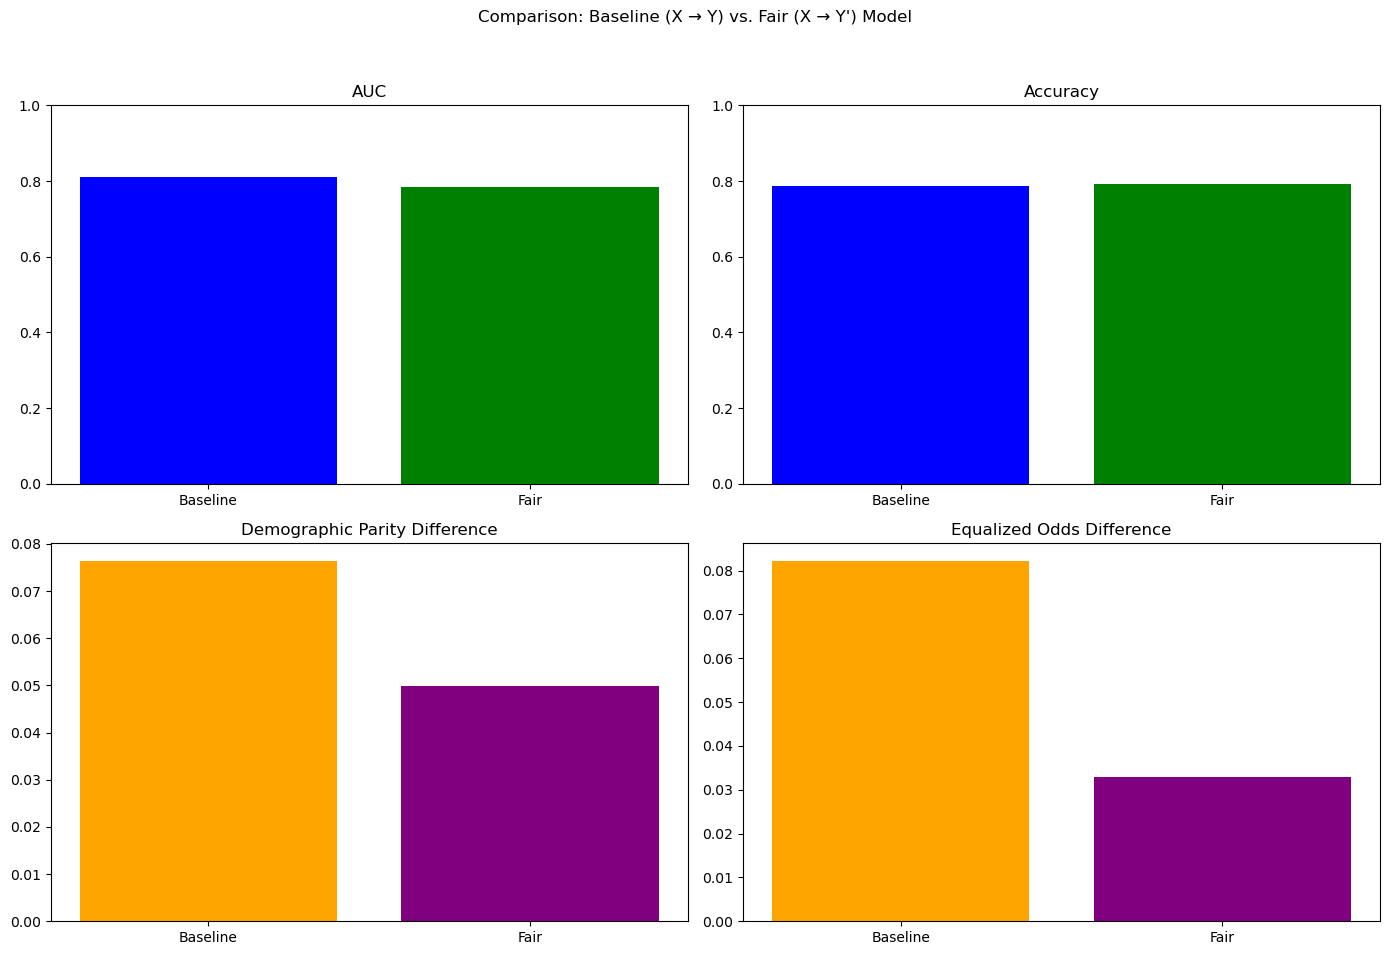

In [14]:
def load_and_preprocess_adult_data(data_url):
    """
    Download and preprocess the UCI Adult dataset.

    Features (X): use only:
       'age', 'education-num', 'marital-status', 'occupation', 'hours-per-week'
    Observed Label (Y): derived from 'income' (binary: 1 if '>50K', 0 otherwise)
    Sensitive attribute (S): derived from 'sex' (binary: 1 if 'Male', 0 if 'Female')

    Returns:
      X: numpy array of shape (n_samples, 5)
      Y: 1-D numpy array of observed labels.
      S: 1-D numpy array of sensitive attribute.
    """
    col_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                 "marital-status", "occupation", "relationship", "race", "sex",
                 "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
    data = pd.read_csv(data_url, header=None, names=col_names, na_values=" ?", skipinitialspace=True)
    data.dropna(inplace=True)

    # Features
    feature_cols = ["age", "education-num", "marital-status", "occupation", "hours-per-week"]
    X = data[feature_cols].copy()
    for col in X.columns:
        if X[col].dtype == object:
            X[col] = pd.Categorical(X[col]).codes
    scaler = StandardScaler()
    X = scaler.fit_transform(X.values.astype(np.float32))

    # Observed label
    data['income'] = data['income'].apply(lambda s: s.replace('.', '').strip())
    y_binary = (data['income'] == '>50K').astype(np.int32)
    Y = y_binary.values  # 1-D array

    # Sensitive attribute
    S = (data['sex'].str.strip() == 'Male').astype(np.int32).values  # 1-D array

    return X, Y, S


adult_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
main(adult_data_url, "adult", lambda_adv=5.0)


#### German Dataset

median age 33.0
Loading and preprocessing german data...
Features shape: (1000, 3)
Observed Label Y shape: (1000,)   (Credit risk: 1=good, 0=bad)
Sensitive Attribute (Age, binarized) shape: (1000,)

Training adversarial model (X → Y' with adversary) ...
Epoch 1/30
7/7 [==============================] - 2s 4ms/step - loss: 3.8267 - pseudo_Y_loss: 0.8625 - S_pred_loss: 0.7837 - Y_pred_loss: 1.0049 - pseudo_Y_accuracy: 0.4963 - S_pred_accuracy: 0.5075 - Y_pred_accuracy: 0.5188
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 3.8026 - pseudo_Y_loss: 0.8536 - S_pred_loss: 0.7842 - Y_pred_loss: 0.9887 - pseudo_Y_accuracy: 0.4863 - S_pred_accuracy: 0.5013 - Y_pred_accuracy: 0.5200
Epoch 3/30
7/7 [==============================] - 0s 14ms/step - loss: 3.7660 - pseudo_Y_loss: 0.8474 - S_pred_loss: 0.7775 - Y_pred_loss: 0.9748 - pseudo_Y_accuracy: 0.4837 - S_pred_accuracy: 0.5000 - Y_pred_accuracy: 0.5138
Epoch 4/30
7/7 [==============================] - 0s 13ms/step - loss:

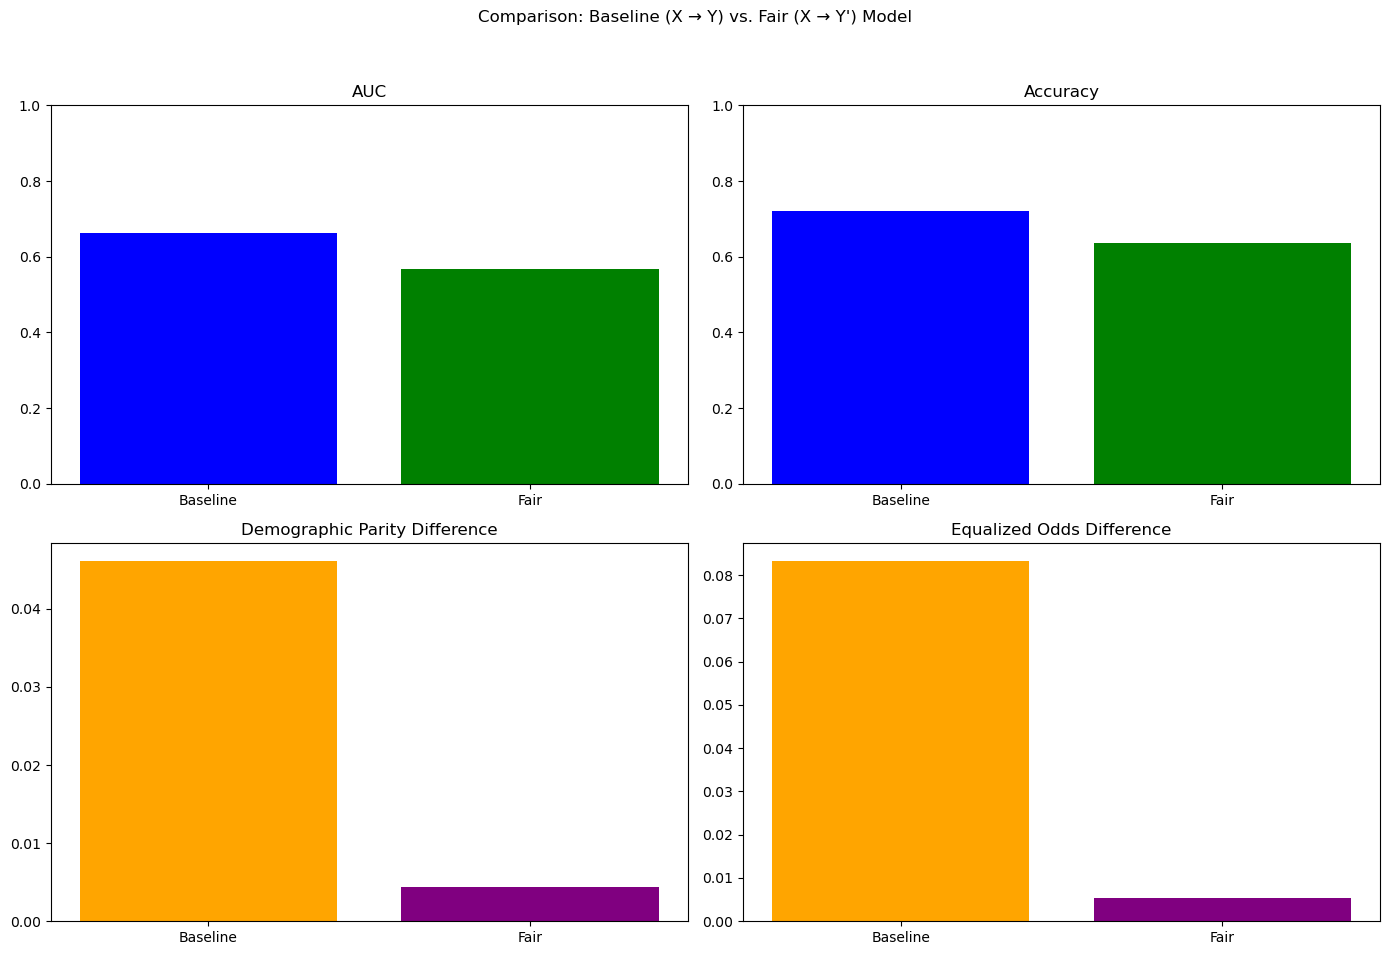

In [22]:
def load_and_preprocess_german_data(data_url):
    """
    Download and preprocess the German Credit dataset.

    We assume the dataset has 21 columns.

    Features (X): Use only:
        "duration", "credit_amount", "inst_rate"
    Observed Label (Y): from "target". In many versions, target is coded as 1 for good and 2 for bad.
        We recode: good (1) -> 1, bad (2) -> 0.
    Protected Attribute (S): Use the "age" column.
        We binarize age by computing the median and setting S = 1 if age >= median (older), else 0.
    """
    col_names = ["chk_status", "duration", "credit_history", "purpose", "credit_amount",
                 "savings", "employment", "inst_rate", "personal_status_sex", "other_debtors",
                 "residence_since", "property", "age", "other_installment_plans", "housing",
                 "num_credits", "job", "num_dependents", "telephone", "foreign_worker", "target"]
    data = pd.read_csv(data_url, header=None, names=col_names, sep=' ', engine='python')

    # Features: use only duration, credit_amount, and inst_rate.
    feature_cols = ["duration", "credit_amount", "inst_rate"]
    X = data[feature_cols].copy().astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.values)

    # Observed label: target. Recode so that 1 -> 1 (good) and 2 -> 0 (bad)
    Y = data["target"].values
    Y = np.where(Y == 1, 1, 0)

    # Protected attribute: use age.
    # Convert age to float and then binarize by the median.
    age_vals = data["age"].astype(np.float32).values
    median_age = np.median(age_vals)
    print("median age", median_age)
    S = (age_vals >= median_age).astype(np.int32)

    return X, Y, S



german_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
main(german_data_url, "german", lambda_adv=2.5)

#### Compas Dataset

Loading and preprocessing compas data...
Features shape: (7214, 5)
Observed Label Y shape: (7214,)   (Recidivism: 1=recid, 0=non-recid)
Sensitive Attribute (Race, binarized) shape: (7214,)

Training adversarial model (X → Y' with adversary) ...
Epoch 1/30
46/46 [==============================] - 2s 8ms/step - loss: 2.4667 - pseudo_Y_loss: 0.7495 - S_pred_loss: 0.8106 - Y_pred_loss: 0.9066 - pseudo_Y_accuracy: 0.5982 - S_pred_accuracy: 0.4188 - Y_pred_accuracy: 0.4952
Epoch 2/30
46/46 [==============================] - 0s 9ms/step - loss: 2.3031 - pseudo_Y_loss: 0.6946 - S_pred_loss: 0.7959 - Y_pred_loss: 0.8125 - pseudo_Y_accuracy: 0.6365 - S_pred_accuracy: 0.4008 - Y_pred_accuracy: 0.5070
Epoch 3/30
46/46 [==============================] - 0s 4ms/step - loss: 2.1636 - pseudo_Y_loss: 0.6604 - S_pred_loss: 0.7605 - Y_pred_loss: 0.7427 - pseudo_Y_accuracy: 0.6488 - S_pred_accuracy: 0.3918 - Y_pred_accuracy: 0.5316
Epoch 4/30
46/46 [==============================] - 0s 3ms/step - loss: 2.

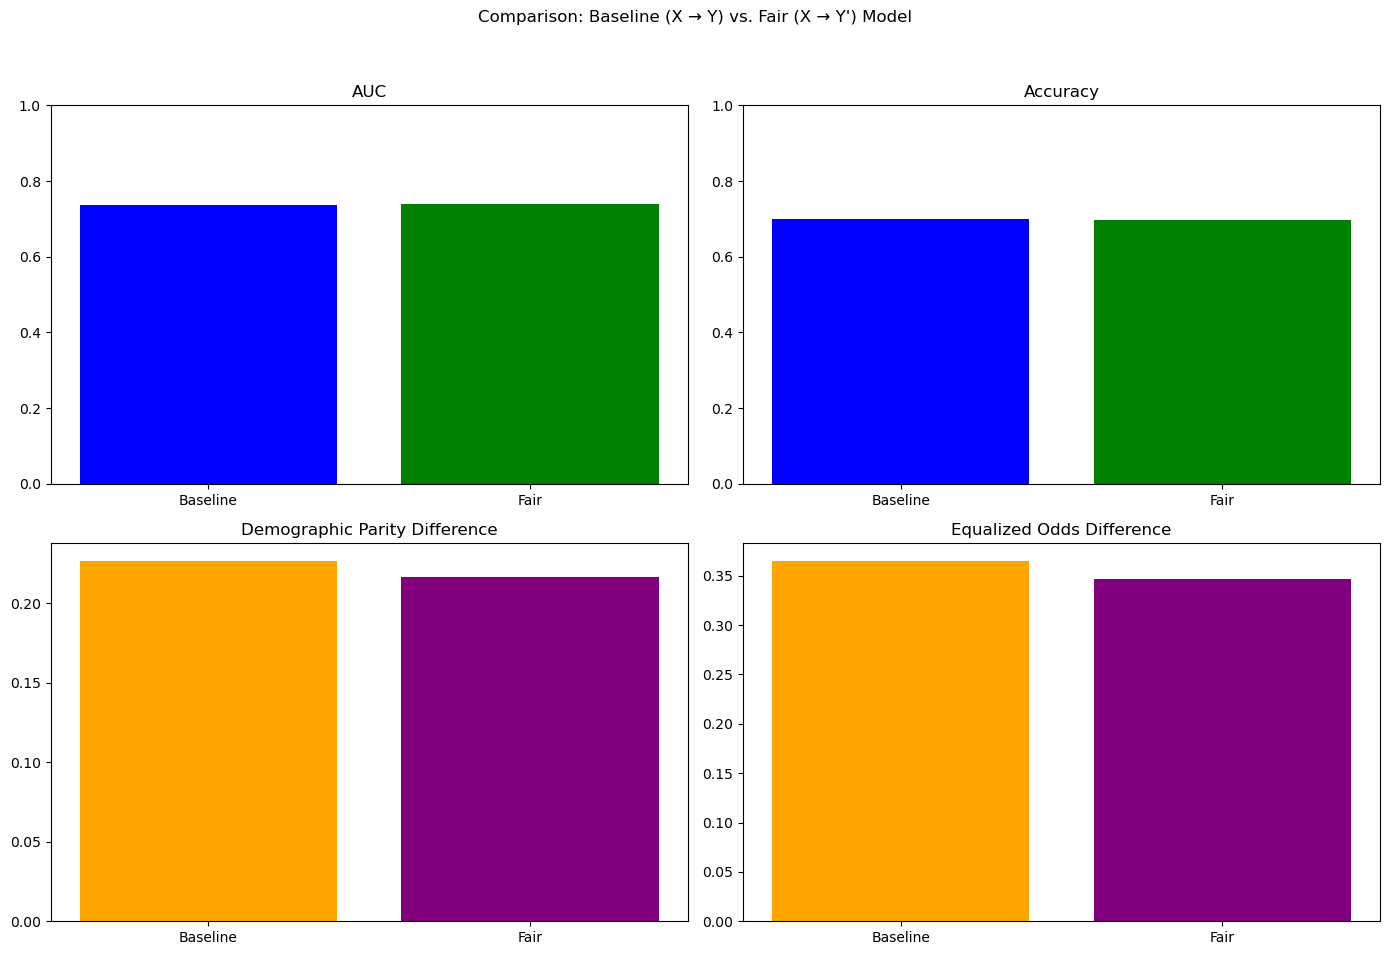

In [17]:
def load_and_preprocess_compas_data_binary(data_url):
    """
    Download and preprocess the COMPAS dataset.

    We assume the dataset contains, among others, the following columns:
      - 'age'
      - 'race'
      - 'priors_count'
      - 'juv_fel_count'
      - 'juv_misd_count'
      - 'juv_other_count'
      - 'two_year_recid'

    Features (X): We select a few numerical features.
    Observed Label (Y): Use 'two_year_recid' as a binary label (0/1).
    Protected Attribute (S): Use 'race'. Here we binarize race so that:
         African‑American  → 1
         all other races  → 0.
    """
    data = pd.read_csv(data_url)
    # Drop rows with missing values in the selected columns.
    data = data.dropna(subset=["age", "race", "priors_count", "juv_fel_count", "juv_misd_count", "juv_other_count", "two_year_recid"])

    # Observed label: two_year_recid (already 0/1)
    Y = data["two_year_recid"].values

    # Sensitive attribute: race. We set S=1 if race is African-American, else 0.
    S = (data["race"] == "African-American").astype(int).values

    # Features: use a subset of numerical features.
    feature_cols = ["age", "priors_count", "juv_fel_count", "juv_misd_count", "juv_other_count"]
    X = data[feature_cols].copy().astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.values)

    return X, Y, S

# URL for the ProPublica COMPAS dataset
compas_data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
# You can adjust lambda_adv as desired (e.g., lambda_adv=15.5 as in your German data experiment)
main(compas_data_url, 'compas', lambda_adv=1.0)

In [10]:
### dataset with binary S and multi-class for Y 


In [11]:
def compute_fairness_metrics_cv(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually along with performance metrics.
    
    y_true: binary ground-truth labels (1-D numpy array).
    y_pred: continuous scores (will be thresholded at 0.5).
    sensitive_features: 1-D numpy array (0 or 1).

    Returns:
      - auc: ROC AUC score.
      - acc: overall accuracy.
      - fairness_metrics: a dictionary with:
          - Demographic parity difference (absolute difference in positive rates).
          - Equalized odds difference (average difference in TPR and FPR).
          - Selection rates per group.
          - Group-wise accuracy.
    """
    # Convert continuous predictions to binary
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Compute performance metrics
    try:
        auc = roc_auc_score(y_true, y_pred)
    except Exception as e:
        auc = np.nan  # Handle cases where AUC can't be computed
    acc = accuracy_score(y_true, y_pred_bin)

    groups = np.unique(sensitive_features)

    # Demographic parity: difference in positive prediction rates between groups
    pos_rates = {}
    for g in groups: 
        pos_rates[g] = np.mean(y_pred_bin[sensitive_features == g])
    dp_diff = abs(pos_rates[0] - pos_rates[1])
    
    # Equalized odds: differences in TPR and FPR between groups
    metrics = {}
    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred_bin[mask]
        tpr = np.sum((y_pred_g == 1) & (y_true_g == 1)) / (np.sum(y_true_g == 1) + 1e-8)
        fpr = np.sum((y_pred_g == 1) & (y_true_g == 0)) / (np.sum(y_true_g == 0) + 1e-8)
        metrics[g] = (tpr, fpr)
    # Average the differences in TPR and FPR between the two groups
    eo_diff = (abs(metrics[0][0] - metrics[1][0]) + abs(metrics[0][1] - metrics[1][1])) / 2.0

    # Selection rates per group (same as positive prediction rates)
    sel_rate = pos_rates

    # Group-wise accuracy
    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred_bin[mask])

    fairness_metrics = {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": sel_rate,
        "group_accuracy": group_acc
    }
    
    return auc, acc, fairness_metrics


In [12]:
#### Cross validation for the 3 datasets 
from sklearn.model_selection import StratifiedKFold
from itertools import product
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


class AdversarialModelWrapperFixed(BaseEstimator, ClassifierMixin):
    """
    Fixed Wrapper for Adversarial Model to work with Grid Search.
    """

    def __init__(self, lambda_adv=1.0, epochs=64, batch_size=128):
        self.lambda_adv = lambda_adv
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y, S):
        """
        Train the adversarial model. S is now passed dynamically per fold.
        """
        y = y.ravel()  # Convert to 1D array
        input_dim = X.shape[1]
        S_oh = tf.keras.utils.to_categorical(S, num_classes=2)

        self.model = build_adversarial_model(input_dim, lambda_adv=self.lambda_adv)
        self.model.fit(
            [X, S_oh],
            {"pseudo_Y": y, "S_pred": S_oh, "Y_pred": y},
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        return self

    def predict(self, X, S):
        """
        Generate predictions from the trained model. S must match X per fold.
        """
        S_oh = tf.keras.utils.to_categorical(S, num_classes=2)
        pseudo_Y, S_pred, Y_pred = self.model.predict([X, S_oh], verbose=0)
        return (pseudo_Y > 0.5).astype(np.float32)

    def score(self, X, y, S, return_metrics=False):
        """
        Compute the optimization score combining AUC, accuracy, and fairness metrics.
        Here, predictions are generated using self.predict.
        """
        # Generate predictions on X using sensitive features S
        y_pred = self.predict(X, S)
        # Compute metrics using a (presumably) provided function
        auc, acc, fairness_metrics = compute_fairness_metrics_cv(
            y_true=y,
            y_pred=y_pred,
            sensitive_features=S
        )
        
        demographic_parity_diff = abs(fairness_metrics["demographic_parity_difference"])
        score = auc + acc - demographic_parity_diff
    
        if return_metrics:
            return score, acc, auc, demographic_parity_diff
        return score

def cross_validation_data(dataset_name, data_url):
    # Load synthetic dataset
    set_seed(42)

    if dataset_name == "compas": 
        X, Y_obs, S = load_and_preprocess_compas_data_binary(data_url) ##  S is binary

    elif dataset_name == "german":
        X, Y_obs, S = load_and_preprocess_german_data(data_url) ##  S is binary

    elif dataset_name == "adult":
        X, Y_obs, S = load_and_preprocess_adult_data(data_url) ##  S is binary

    else:
        print ("Invalid dataset_name")
        return 
    

    print(f"Loading and preprocessing {dataset_name} data...")
    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y_obs, S, test_size=0.2, random_state=42
    )
    
    # Convert to a 1D array
    Y_train_obs = Y_train_obs.ravel()
    
    param_grid = {
        "lambda_adv": [1.0, 3.0, 5.0, 7.0, 15.0],
        "epochs": [32, 64, 128],
        "batch_size": [64, 128, 256]
    }
    
    # Custom cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Store results
    results = []
    
    # Perform manual grid search
    for lambda_adv, epochs, batch_size in product(param_grid["lambda_adv"], param_grid["epochs"], param_grid["batch_size"]):
        scores, accuracies, aucs, demographic_parity_diffs = [], [], [], []
        
        print(f"\nTesting lambda_adv={lambda_adv}, epochs={epochs}, batch_size={batch_size}")
        
        for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, Y_train_obs)):  # Ensure Y_train is used for stratification
            # Split data
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            Y_train_fold, Y_val_fold = Y_train_obs[train_idx], Y_train_obs[val_idx]
            S_train_fold, S_val_fold = S_train[train_idx], S_train[val_idx]

    
            # Train model
            model = AdversarialModelWrapperFixed(lambda_adv=lambda_adv, epochs=epochs, batch_size=batch_size)
            model.fit(X_train_fold, Y_train_fold, S=S_train_fold)

            # Obtain predictions from the trained model
            Y_train_pred = model.predict(X_train_fold, S_train_fold)  
            Y_val_pred = model.predict(X_val_fold, S_val_fold)  
            
            # Evaluate model
            score, accuracy, auc, demographic_parity_diff = model.score(
                X_val_fold,
                Y_val_fold,
                S_val_fold,
                return_metrics=True
            )


            scores.append(score)
            accuracies.append(accuracy)
            aucs.append(auc)
            demographic_parity_diffs.append(demographic_parity_diff)
    
            # Print results per fold
            print(f"  Fold {fold + 1}: Score={score:.4f}, Accuracy={accuracy:.4f}, AUC={auc:.4f}, Demographic Parity Diff={demographic_parity_diff:.4f}")
    
        # Store average scores across folds
        avg_score = np.mean(scores)
        avg_accuracy = np.mean(accuracies)
        avg_auc = np.mean(aucs)
        avg_demographic_parity_diff = np.mean(demographic_parity_diffs)
    
        results.append({
            "lambda_adv": lambda_adv,
            "epochs": epochs,
            "batch_size": batch_size,
            "score": avg_score,
            "accuracy": avg_accuracy,
            "auc": avg_auc,
            "demographic_parity_diff": avg_demographic_parity_diff
        })
    
        print(f"  Final (Avg) for lambda_adv={lambda_adv}, epochs={epochs}, batch_size={batch_size}: "
              f"Score={avg_score:.4f}, Accuracy={avg_accuracy:.4f}, AUC={avg_auc:.4f}, Demographic Parity Diff={avg_demographic_parity_diff:.4f}")
    
        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        # Find best hyperparameters
        best_params = results_df.loc[results_df["score"].idxmax()]
        print("\nBest Hyperparameters:", best_params)



In [16]:
# compas_data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
# cross_validation_data("compas", compas_data_url)

KeyboardInterrupt: 